In [57]:
import torch
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

In [58]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "clean"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000", "musdb_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/w49so2fn/checkpoints/epoch=40-step=25625.ckpt"

In [59]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [60]:
dataset = PairedAudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=131_072,
    effect_input=False,
    effect_output=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 43438.71it/s]


Loaded 88 files for train = 66.89 hours.


In [61]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)

In [62]:
batch = next(iter(loader))
x, y = batch

In [63]:
x.shape

torch.Size([1, 1, 131072])

In [64]:
x_s = model.audio_to_spectrogram(signal=x)
y_s = model.audio_to_spectrogram(signal=y)

In [65]:
X = torch.concat([x_s, y_s], dim=1)

In [66]:
X.shape

torch.Size([1, 4, 65, 2049])

In [67]:
X_hat, _, _ = model(X)

In [68]:
X_hat.shape

torch.Size([1, 4, 65, 2049])

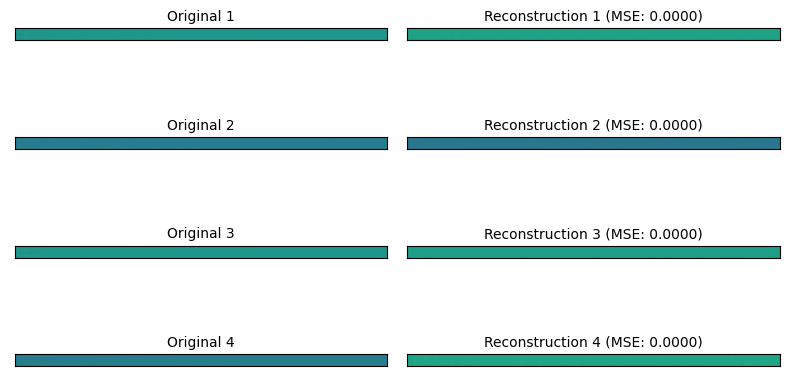

In [70]:
import torch.nn.functional as F

fig, axes = plt.subplots(4, 2, figsize=(8,5))


mse = F.mse_loss(X, X_hat)

# for each dimension
for i in range(4):
    ax1 = axes[i, 0].imshow(X[:,i,:,:].detach().squeeze().numpy())
    ax2 = axes[i, 1].imshow(X_hat[:,i,:,:].detach().squeeze().numpy())

    axes[i, 0].set_title(f"Original {i+1}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {i+1} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([.9, 0.15, 0.05, 0.7])
# fig.colorbar(ax1, cax=cbar_ax)

plt.tight_layout()
plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")
# plt.show()

(array([1.00000e+00, 1.30000e+01, 7.50000e+01, 4.79000e+02, 5.25600e+03,
        1.25874e+05, 1.22000e+03, 2.17000e+02, 4.70000e+01, 3.00000e+00]),
 array([-0.08044962, -0.06511936, -0.04978909, -0.03445882, -0.01912856,
        -0.00379829,  0.01153197,  0.02686224,  0.0421925 ,  0.05752277,
         0.07285304]),
 <BarContainer object of 10 artists>)

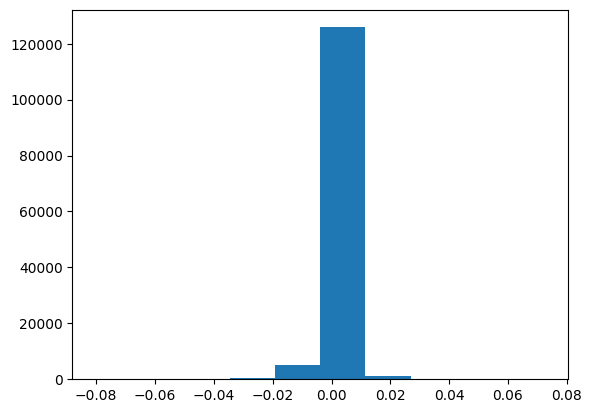

In [77]:
plt.hist(X[:,0,:,:].detach().ravel())

In [82]:
X[:,3,:,:].std()

tensor(0.0036, grad_fn=<StdBackward0>)